In [390]:
import math
import os
from pathlib import Path
import sys
sys.path.insert(0, '..')
import pandas as pd
import yaml
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import energy_flexibility_kpis.kpi.energy_flexibility.demand_profile_reshaping as demand_profile_reshaping
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_costs_or_savings as demand_response_costs_or_savings
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_emission_or_environmental_impact as demand_response_emission_or_environmental_impact
import energy_flexibility_kpis.kpi.energy_flexibility.demand_response_energy_efficiency as demand_response_energy_efficiency
import energy_flexibility_kpis.kpi.energy_flexibility.energy_or_average_power_load_shedding as energy_or_average_power_load_shedding
import energy_flexibility_kpis.kpi.energy_flexibility.energy_storage_capability as energy_storage_capability
import energy_flexibility_kpis.kpi.energy_flexibility.grid_interaction as grid_interaction
import energy_flexibility_kpis.kpi.energy_flexibility.impact_on_ieq as impact_on_ieq
import energy_flexibility_kpis.kpi.energy_flexibility.load_shifting as load_shifting
import energy_flexibility_kpis.kpi.energy_flexibility.peak_power_or_energy_rebound as peak_power_or_energy_rebound
import energy_flexibility_kpis.kpi.energy_flexibility.peak_power_shedding as peak_power_shedding
import energy_flexibility_kpis.kpi.energy_flexibility.valley_filling as valley_filling
from energy_flexibility_kpis.utilities import FileHandler

# Package File Structure
---

In [391]:
!tree ../energy_flexibility_kpis -P '*.py' -I '__pycache__'

Too many parameters - -P


# How to get the info for a KPI
---

In [392]:
peak_power_or_energy_rebound.PeakPowerRebound.info()
#peak_power_shedding.PeakPowerReduction.info()["name"]

{'name': 'peak power rebound',
 'definition': 'Power demand increase during peak hour after flexible operation (rebound effect). The evaluation window should be set to the rebound period.',
 'unit': 'kW',
 'category': 'EF KPI: Peak Power/Energy Rebound',
 'relevance': 3,
 'stakeholders': ['distribution system operator',
  'transmisssion system operator'],
 'complexity': 1,
 'need_baseline': True,
 'temporal_evaluation_window': 'single event',
 'temporal_resolution': 'unspecified',
 'spatial_resolution': 'single building',
 'doe_flexibility_category': ['load shifting', 'load shedding'],
 'performance_aspect': ['power'],
 'calculation_arguments': [{'name': 'baseline electric power profile',
   'snake_case_name': 'baseline_electric_power_profile',
   'definition': 'A time series data points of electric power demand acquired in baseline operation scenario.',
   'primitive_type': {'name': 'power demand',
    'definition': 'An instantaneous power demand of a entity at a moment.',
    'unit':

# KPI Calculation Function Design Choices
---
1. All KPIs have a `calculate` function whose arguments refer to the variables listed in the [variables sheet](https://docs.google.com/spreadsheets/d/1tSN3PIu-lh9aSiU775-RULTRy2o2owIzV-iwymNXszo/edit#gid=118080661).
2. Every KPIs `calculate` function has positional arguments that must be provided and keyword arguments that are optional. The positional arguments will typically include power and energy profile e.g., `generic_electric_power_profile`, `flexible_electric_power_profile`, e.t.c. In some cases, `timestamps` variable is required e.g. in `energy_or_average_power_load_shedding.AnnualAverageDailyLoadVariation` where `timestamps` variable is needed to infer `hour-of-day` and `day-of-year` variables.
1. Every KPI's `calculate` function has `timestamps`, `evaluation_start_timestamp` and `evaluation_end_timestamp` as optional arguments so that the user can at any time supply the full power or energy profile and only need to control the `evaluation_start_timestamp` and `evaluation_end_timestamp` variables to consider specific time periods during calculation.
2. `timestamps` can be a datetime series of a timestep series i.e. integers.
3. KPIs that are defined for a building or DER cluster will take in a list of lists for some variables instead of taking in a single list of values
4. Writing all KPIs with the assumption that the input variables are in SI unit and values are reported as such eg. time in seconds, power in kW, energy in kWh.

# User input (config file)
---

In [405]:
# Define config path 
config_path = 'config_file_incite.yaml'
#config_path = 'config_file_multizone_office_simple_air.yaml'

In [406]:
# Validate common/basic inputs from config path

def validate_yaml(data):
    required_keys = [
        'path_to_dataset',
        'brick_model_file_name',
        'database_file_name',
        'updated_brick_model_file_name', 
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',       
    ]

    for key in required_keys:
        if key not in data:
            config_file_validation = False
            return config_file_validation, f"Key '{key}' is missing in the config file."
        config_file_validation = True
    return config_file_validation,  "Basic inputs from config file are valid."

# Load the YAML file
with open(config_path, 'r') as file:
    config_file_data = yaml.safe_load(file)

# Validate the YAML file
config_file_validation, message = validate_yaml(config_file_data)

# Print the validation result
if config_file_validation:
    print(message)
    # Access the data
    path_to_dataset = config_file_data['path_to_dataset']
    brick_model_file_name = config_file_data['brick_model_file_name']
    database_file_name = config_file_data['database_file_name']
    updated_brick_model_file_name = config_file_data['updated_brick_model_file_name']
    baseline_scenario = config_file_data.get('baseline_scenario', None)
    flexible_scenario = config_file_data.get('flexible_scenario', None)
    evaluation_timestamps = [(
        pd.Timestamp(config_file_data['evaluation_timestamps']['start']),
        pd.Timestamp(config_file_data['evaluation_timestamps']['end'])
    )]

else:
    print(f"Validation failed: {message}")


Basic inputs from config file are valid.


# Validating a Dataset

In [395]:
data_directory = Path(path_to_dataset)
print(data_directory)

..\data\incite_dataset


### Validating a Brick model

In [396]:
# Define manifest paths (metadata requirements for the KPIs)
manifest_paths = {'average demand decrease index':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_decrease_index.ttl',
                  'average demand decrease':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_decrease.ttl',
                  'average demand decrease intensity':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_decrease_intensity.ttl',
                  'average demand increase index':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_increase_index.ttl',
                  'average demand increase':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_increase.ttl',
                  'average demand increase intensity':'validation_buildingMOTIF/manifests_kpis/manifest_average_demand_increase_intensity.ttl',
                  'average power rebound index':'validation_buildingMOTIF/manifests_kpis/manifest_average_power_rebound_index.ttl',
                  'average power rebound':'validation_buildingMOTIF/manifests_kpis/manifest_average_power_rebound.ttl',
                  'energy savings of demand response':'validation_buildingMOTIF/manifests_kpis/manifest_energy_savings_of_demand_response.ttl',
                  'flexibility savings index':'validation_buildingMOTIF/manifests_kpis/manifest_flexibility_savings_index.ttl',
                  'net building consumption change percentage':'validation_buildingMOTIF/manifests_kpis/manifest_net_building_consumption_change_percentage.ttl',
                  'peak power reduction':'validation_buildingMOTIF/manifests_kpis/manifest_peak_power_reduction.ttl'
                  }


In [397]:
from validation_buildingMOTIF.kpis_validation import ValidationInterface

# Initialize validation interface
validator = ValidationInterface(os.path.join(data_directory,brick_model_file_name), manifest_paths)

# Run validation
suitable_kpis_brick = []
suitable_kpis_brick = validator.validate()
suitable_kpis_brick = [list(d)[0] for d in suitable_kpis_brick]

print('Suitable KPIs according to metadata in the Brick model',suitable_kpis_brick)

 For KPI average demand decrease intensity - urn:incite_example/building needs between 1 and None uses of path https://brickschema.org/schema/Brick#area
 For KPI average demand increase intensity - urn:incite_example/building needs between 1 and None uses of path https://brickschema.org/schema/Brick#area
╒════════════════════════════════════════════╤═════════════════════╕
│ KPI                                        │ Validation Result   │
╞════════════════════════════════════════════╪═════════════════════╡
│ average demand decrease index              │ True                │
├────────────────────────────────────────────┼─────────────────────┤
│ average demand decrease                    │ True                │
├────────────────────────────────────────────┼─────────────────────┤
│ average demand decrease intensity          │ False               │
├────────────────────────────────────────────┼─────────────────────┤
│ average demand increase index              │ True                │
├───

### Validating a Config file

In [407]:
# Define the dictionary of KPIs and their required keys
kpi_required_keys = {
    'average demand decrease index':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier'
    ],
    'average demand decrease':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier'
    ],
    'average demand decrease intensity':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier'
    ],
    'average demand increase index':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',
        'shift_window'
    ],
    'average demand increase':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',
        'shift_window'
    ],
    'average demand increase intensity':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',
        'shift_window'
    ],
    'average power rebound index':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',
        'rebound_window'
    ],
    'average power rebound':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier',
        'rebound_window'
    ],
    'energy savings of demand response':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'timestamp_identifier'
    ],
    'flexibility savings index':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'price_signal_file_name',
        'price_signal_identifier',
        'timestamp_identifier'
    ],
    'net building consumption change percentage':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'timestamp_identifier'
    ],
    'peak power reduction':[
        'baseline_scenario',
        'flexible_scenario',
        'evaluation_timestamps',
        'timestamp_identifier'
    ],
}
def validate_yaml(data, kpi_name):
    # Get the required keys for the specified KPI
    required_keys = kpi_required_keys.get(kpi_name, [])
    
    # Collect missing metadata for the KPI
    missing_metadata = [key for key in required_keys if key not in data]

    if not missing_metadata:
        return True, f"KPI '{kpi_name}' is valid.", missing_metadata
    else:
        return False, f"KPI '{kpi_name}' is missing metadata: {', '.join(missing_metadata)}", missing_metadata

# Load the YAML file
with open(config_path, 'r') as file:
    config_file_data = yaml.safe_load(file)

# Specify the list of KPIs you want to validate
kpis_to_validate = list(kpi_required_keys.keys())

# Create a table to display results
table = PrettyTable()
table.field_names = ["KPI", "Config file validation result"]

# Collect missing metadata for each KPI
missing_metadata_results = {}
unique_missing_metadata = set()
suitable_kpis_config_file = []

# Validate the YAML file for each specified KPI
for kpi_to_validate in kpis_to_validate:
    is_valid, message, missing_metadata = validate_yaml(config_file_data, kpi_to_validate)

    # Add row to the table
    table.add_row([kpi_to_validate, is_valid])
    
    unique_missing_metadata.update(missing_metadata)

    if is_valid:
        suitable_kpis_config_file.append(kpi_to_validate)
    else:
        missing_metadata_results[kpi_to_validate] = message

# Print the table
print(table)
print('Suitable KPIs according to metadata in the config file',suitable_kpis_config_file)
# Print missing metadata for each KPI
for kpi_name, missing_metadata_message in missing_metadata_results.items():
    print(missing_metadata_message)
print ('Missing unique metadata in the config file', unique_missing_metadata)


+--------------------------------------------+-------------------------------+
|                    KPI                     | Config file validation result |
+--------------------------------------------+-------------------------------+
|       average demand decrease index        |              True             |
|          average demand decrease           |              True             |
|     average demand decrease intensity      |              True             |
|       average demand increase index        |              True             |
|          average demand increase           |              True             |
|     average demand increase intensity      |              True             |
|        average power rebound index         |              True             |
|           average power rebound            |              True             |
|     energy savings of demand response      |              True             |
|         flexibility savings index          |      

### Combined validation result

In [399]:
suitable_kpis = list(set(suitable_kpis_brick) & set(suitable_kpis_config_file))
print ('Suitable KPIs according to metadata in the Brick model and config file', suitable_kpis)

Suitable KPIs according to metadata in the Brick model and config file ['average power rebound', 'average power rebound index', 'average demand decrease index', 'energy savings of demand response', 'average demand decrease', 'average demand increase index', 'net building consumption change percentage', 'flexibility savings index', 'peak power reduction', 'average demand increase']


# Importing a Dataset
---

In [408]:
all_available_metadata = set(key for kpi_keys in kpi_required_keys.values() for key in kpi_keys) - unique_missing_metadata
print (all_available_metadata)

# Load the YAML file
with open(config_path, 'r') as file:
    config_file_data = yaml.safe_load(file)

# Fetch data only for keys in all_required_keys
filtered_config_file_data = {key: config_file_data[key] for key in all_available_metadata if key in config_file_data}

# Access the filtered data
price_signal_file_name = filtered_config_file_data.get('price_signal_file_name', None)
timestamp_identifier = filtered_config_file_data.get('timestamp_identifier', None)
price_signal_identifier = filtered_config_file_data.get('price_signal_identifier', None)
shift_window = filtered_config_file_data.get('shift_window', None)
rebound_window = filtered_config_file_data.get('rebound_window', None)

{'flexible_scenario', 'price_signal_file_name', 'price_signal_identifier', 'rebound_window', 'timestamp_identifier', 'baseline_scenario', 'shift_window', 'evaluation_timestamps'}


### Edit Brick model 
Include references to csv files per datapoint

In [401]:
import duckdb
import pandas as pd
import glob
import rdflib
from pathlib import Path
from rdflib import Namespace, Literal, Graph, BNode
from rdflib import RDF, RDFS, BRICK

A = RDF.type
REF = Namespace("https://brickschema.org/schema/Brick/ref#")
BLDG = Namespace("urn:boptest_example/")

model = Graph()
model.bind("ref", REF)
model.bind("rdfs", RDFS)
model.bind("brick", BRICK)
model.bind("bldg", BLDG)

# load base model from file
model.parse(os.path.join(data_directory,brick_model_file_name))

db = duckdb.connect(database_file_name)

# load in the CSV files
for filename in glob.glob(os.path.join(data_directory, "*.csv")):
    print(filename)
    table_name = Path(filename).name.split('.')[0]
    df = pd.read_csv(filename, skiprows=[1])
    df['Timestamp'] = pd.to_datetime(df.pop(timestamp_identifier))
    # remove first row -- it is the unit declarations
    df.drop(1, axis=0)
    db.execute(f"DROP TABLE IF EXISTS {table_name}")

    db.execute(f"CREATE TABLE {table_name} AS SELECT * FROM df")

    # add the annotation to the Brick model
    for pointlabel in df.columns:
        point = list(model.query(f'SELECT ?point WHERE {{ ?point ref:hasExternalReference ?ref . ?ref ref:hasTimeseriesId "{pointlabel}" }}'))

        if not point:
            continue
        point = point[0][0]
        reference = BNode()
        model.add((point, REF.hasExternalReference, reference))
        model.add((reference, A, REF.TimeseriesReference))
        model.add((reference, REF.hasTimeseriesId, Literal(pointlabel)))
        model.add((reference, REF.onTable, Literal(table_name)))
        model.add((reference, REF.storedAt, Literal("data.db")))
model.serialize(os.path.join(data_directory,updated_brick_model_file_name))
# save data to duckdb
db.commit()

..\data\incite_dataset\dataset_MPC_Co2_Cool.csv
..\data\incite_dataset\dataset_MPC_Co2_Heat.csv
..\data\incite_dataset\dataset_MPC_Cost_Cool.csv
..\data\incite_dataset\dataset_MPC_Cost_Heat.csv
..\data\incite_dataset\dataset_RBC_Co2_Cool.csv
..\data\incite_dataset\dataset_RBC_Co2_Heat.csv
..\data\incite_dataset\dataset_RBC_Cost_Cool.csv
..\data\incite_dataset\dataset_RBC_Cost_Heat.csv
..\data\incite_dataset\dataset_Ref_Cool.csv
..\data\incite_dataset\dataset_Ref_Heat.csv
..\data\incite_dataset\Ref_Cool.csv


C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\2898785817.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df.pop(timestamp_identifier))


..\data\incite_dataset\Ref_Heat.csv


C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\2898785817.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df.pop(timestamp_identifier))


# Map Dataset to EFONT Variables
---

In [402]:
# Parse graph
g = rdflib.Graph()
g.parse(os.path.join(data_directory,updated_brick_model_file_name))
# Establish a connection to DuckDB database
db = duckdb.connect(database=database_file_name)

scenarios = {
    baseline_scenario: 'baseline_',
    flexible_scenario: 'flexible_'
}

data_dict = {}

for scenario, column_name in scenarios.items():
    query = f"""
    PREFIX ref: <https://brickschema.org/schema/Brick/ref#>
    SELECT ?power_point WHERE {{
        ?point a brick:Electric_Power_Sensor ;
            ref:hasExternalReference ?ref .
        ?ref ref:onTable "{scenario}" ;
            ref:hasTimeseriesId ?power_point .

    }}"""

    # Convert the rows to a dictionary for DataFrame creation
    for row in g.query(query):
        #print(row)
        power_point = row [0]
        duck_query_label = f"SELECT Timestamp, {power_point} FROM {scenario}"
        
        res_label = db.execute(duck_query_label)
        timestamp_values_label = res_label.fetchall()
        #for row in timestamp_values_label[:5]:
        #    print(row)

        # Extract timestamps and values from the rows
        timestamps_label, values_label = zip(*timestamp_values_label)

        # Resample the values
        values_series_label = pd.Series(values_label, index=timestamps_label)
        
        resampled_series_label = values_series_label.resample('15T').mean()

        # TO DO: add unit in the graph, query it and depending on the unit convert the values (eg from W to kW)

        # Create columns for label and sensor data for each scenario
        if f'{column_name}electric_power_profile' in data_dict:
            data_dict[f'{column_name}electric_power_profile'] += resampled_series_label
        else:
            data_dict[f'{column_name}electric_power_profile'] = resampled_series_label


# Create a DataFrame from the data dictionary
data = pd.DataFrame(data_dict)

# Reset the index to convert the timestamp index to a column
data = data.rename_axis('timestamp').reset_index()

# Print the DataFrame
display(data.head(5))
display(data.tail(10))


,timestamp,baseline_electric_power_profile,flexible_electric_power_profile
0,2016-07-08 00:00:00,1.370894,3.078967
1,2016-07-08 00:15:00,1.304929,1.253622
2,2016-07-08 00:30:00,1.445964,1.337895
3,2016-07-08 00:45:00,1.031832,1.189204
4,2016-07-08 01:00:00,0.098187,1.218056


,timestamp,baseline_electric_power_profile,flexible_electric_power_profile
279,2016-07-10 21:45:00,0.097792,2.291629
280,2016-07-10 22:00:00,0.097024,0.287923
281,2016-07-10 22:15:00,0.096278,0.094426
282,2016-07-10 22:30:00,0.096053,0.094809
283,2016-07-10 22:45:00,0.096099,0.094926
284,2016-07-10 23:00:00,0.096084,2.285714
285,2016-07-10 23:15:00,0.096093,1.803157
286,2016-07-10 23:30:00,0.097716,1.125977
287,2016-07-10 23:45:00,0.096809,1.213050
288,2016-07-11 00:00:00,NaN,0.138150


### Utility function: price threshold

In [403]:
def get_price_threshold(price_schedule): 
   
    # Sort the prices in ascending order
    price_schedule.sort()

    # Calculate the index of the third quartile
    n = len(price_schedule)
    k = (3.0 * n - 1) / 4

    # Determine the price threshold as the third quartile
    if k == int(k):
        priceThreshold = price_schedule[int(k) - 1]
    else:
        priceThreshold = (price_schedule[int(k) - 1] + price_schedule[int(k)]) / 2

    return priceThreshold

### Utility function: shed timestamp

In [409]:
if all(var is not None for var in [price_signal_file_name, timestamp_identifier, price_signal_file_name]):

    # Read the DataFrame from a CSV file
    price_df = pd.read_csv(os.path.join(data_directory,price_signal_file_name))

    # Extract the start and end times from the evaluation timestamp
    start_time, end_time = evaluation_timestamps[0]

    # Filter the DataFrame to include only rows within the specified time range
    price_df[timestamp_identifier] = pd.to_datetime(price_df[timestamp_identifier])
    filtered_price_df = price_df[(price_df[timestamp_identifier] >= start_time) & (price_df[timestamp_identifier] <= end_time)]
    display(filtered_price_df.head(15))
    price_values = filtered_price_df[price_signal_identifier].tolist()
    #print(price_values)
    price_threshold = get_price_threshold(price_values)
    print('Price threshold', price_threshold)

    # Filter the rows where price_signal is greater than price_threshold
    shed_price_df = filtered_price_df[filtered_price_df[price_signal_identifier] >= price_threshold]

    # Print the DataFrame
    display(shed_price_df.head(15))

    shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])
    unique_dates = shed_price_df[timestamp_identifier].dt.strftime('%Y-%m-%d').unique()

    # Create list of signal timestamps
    signal_timestamps = []

    for day in pd.date_range(start_time, end_time, freq='D'):
        matching_date = str(day.date())
        
        # Check if there are any rows in df where the date matches the current date
        if matching_date in unique_dates:
            group = shed_price_df[shed_price_df[timestamp_identifier].dt.date == day.date()]
            group['time'] = group[timestamp_identifier].dt.strftime('%H:%M:%S')  # Convert to string for comparison
            # Ensure the 'time' column is in datetime format
            group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')
            start_time = None

            for index, row in enumerate(group.itertuples()):
                if start_time is None:
                    start_time = row.time
                elif row.time - group['time'].iloc[index - 1] != pd.Timedelta(minutes=1):
                    end_time = group['time'].iloc[index - 1].replace(second=59, minute=59)
                    signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))
                    start_time = row.time

            if start_time is not None:
                end_time = group['time'].iloc[-1].replace(second=59, minute=59)
                signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))

    # Display the result
    print(signal_timestamps)

    shed_signal_timestamps = []
    if signal_timestamps:
        current_start, current_end = signal_timestamps[0]

        for start, end in signal_timestamps[1:]:
            if start <= current_end + pd.Timedelta(seconds=1):
                current_end = max(end, current_end)
            else:
                shed_signal_timestamps.append((current_start, current_end))
                current_start, current_end = start, end

        shed_signal_timestamps.append((current_start, current_end))

    print(shed_signal_timestamps)

,Timestamp,Indoor_Tind_avg,Indoor_Twall_avg,Weather_Tamb,Weather_RH,Weather_Irr,Weather_WindVel,HP_Pel,HP_DHWon,HP_SCon,HP_DHWtank_Temp,HP_FreqCompr,HP_Tsup,HP_Tret,Price,CO2_MEF
0,2016-07-08 00:00:00,24.400000,25.560000,24.110000,77.310000,0.0,0.890000,1.786763,0.0,1.0,42.000000,45.000000,12.900000,15.461667,60.76,0.273194
1,2016-07-08 00:01:00,24.410000,25.560000,24.110000,77.360000,0.0,0.900000,2.003613,0.0,1.0,42.000000,45.000000,11.828333,14.918333,60.76,0.273194
2,2016-07-08 00:02:00,24.410000,25.560000,24.110000,77.410000,0.0,0.910000,2.290932,0.0,1.0,44.000000,44.666667,12.065000,17.018333,60.76,0.273194
3,2016-07-08 00:03:00,24.390000,25.560000,24.110000,77.460000,0.0,0.910000,2.539837,0.0,1.0,44.000000,43.333333,13.413333,17.875000,60.76,0.273194
4,2016-07-08 00:04:00,24.370000,25.550000,24.110000,77.510000,0.0,0.910000,2.258608,0.0,1.0,44.000000,38.000000,14.118333,17.623333,60.76,0.273194
5,2016-07-08 00:05:00,24.350000,25.550000,24.110000,77.560000,0.0,0.920000,2.019772,0.0,1.0,44.000000,37.333333,13.878333,16.546667,60.76,0.273194
6,2016-07-08 00:06:00,24.340000,25.540000,24.110000,77.590000,0.0,0.910000,1.900923,0.0,1.0,42.666667,36.666667,13.085000,15.361667,60.76,0.273194
7,2016-07-08 00:07:00,24.320000,25.540000,24.110000,77.600000,0.0,0.880000,1.817875,0.0,1.0,44.000000,35.333333,12.343333,15.120000,60.76,0.273194
8,2016-07-08 00:08:00,24.310000,25.530000,24.100000,77.610000,0.0,0.850000,1.692105,0.0,1.0,44.000000,33.333333,12.681667,15.438333,60.76,0.273194
9,2016-07-08 00:09:00,24.290000,25.530000,24.100000,77.620000,0.0,0.820000,1.530158,0.0,1.0,44.000000,31.333333,13.275000,15.968333,60.76,0.273194


Price threshold 119.62


,Timestamp,Indoor_Tind_avg,Indoor_Twall_avg,Weather_Tamb,Weather_RH,Weather_Irr,Weather_WindVel,HP_Pel,HP_DHWon,HP_SCon,HP_DHWtank_Temp,HP_FreqCompr,HP_Tsup,HP_Tret,Price,CO2_MEF
780,2016-07-08 13:00:00,25.850,26.466667,28.403333,57.433333,3259.360000,1.366667,0.095288,0.0,0.0,40.0,0.0,24.688333,25.168333,120.89,0.205642
781,2016-07-08 13:01:00,25.850,26.480000,28.330000,57.596667,3260.310000,1.353333,0.095650,0.0,0.0,40.0,0.0,24.738333,25.333333,120.89,0.205642
782,2016-07-08 13:02:00,25.850,26.480000,28.273333,57.746667,3260.493333,1.333333,0.096957,0.0,0.0,40.0,0.0,24.731667,25.345000,120.89,0.205642
783,2016-07-08 13:03:00,25.850,26.480000,28.223333,57.836667,3260.136667,1.313333,0.097570,0.0,0.0,40.0,0.0,24.737500,25.317500,120.89,0.205642
784,2016-07-08 13:04:00,25.850,26.480000,28.175000,57.895000,3259.340000,1.295000,0.096690,0.0,0.0,40.0,0.0,24.755000,25.338333,120.89,0.205642
785,2016-07-08 13:05:00,25.855,26.480000,28.145000,57.945000,3258.040000,1.280000,0.097468,0.0,0.0,40.0,0.0,24.733333,25.358333,120.89,0.205642
786,2016-07-08 13:06:00,25.860,26.485000,28.135000,57.995000,3255.565000,1.260000,0.097447,0.0,0.0,40.0,0.0,24.740000,25.333333,120.89,0.205642
787,2016-07-08 13:07:00,25.860,26.490000,28.155000,58.030000,3252.355000,1.235000,0.097287,0.0,0.0,40.0,0.0,24.763333,25.350000,120.89,0.205642
788,2016-07-08 13:08:00,25.860,26.490000,28.185000,58.025000,3249.540000,1.200000,0.095697,0.0,0.0,40.0,0.0,24.751667,25.365000,120.89,0.205642
789,2016-07-08 13:09:00,25.860,26.490000,28.220000,58.000000,3248.255000,1.160000,0.095820,0.0,0.0,40.0,0.0,24.721667,25.270000,120.89,0.205642


[(Timestamp('2016-07-08 13:00:00'), Timestamp('2016-07-08 17:59:59')), (Timestamp('2016-07-08 21:00:00'), Timestamp('2016-07-08 22:59:59')), (Timestamp('2016-07-09 13:00:00'), Timestamp('2016-07-09 15:59:59')), (Timestamp('2016-07-09 19:00:00'), Timestamp('2016-07-09 22:59:59')), (Timestamp('2016-07-10 14:00:00'), Timestamp('2016-07-10 15:59:59')), (Timestamp('2016-07-10 20:00:00'), Timestamp('2016-07-10 22:59:59'))]
[(Timestamp('2016-07-08 13:00:00'), Timestamp('2016-07-08 17:59:59')), (Timestamp('2016-07-08 21:00:00'), Timestamp('2016-07-08 22:59:59')), (Timestamp('2016-07-09 13:00:00'), Timestamp('2016-07-09 15:59:59')), (Timestamp('2016-07-09 19:00:00'), Timestamp('2016-07-09 22:59:59')), (Timestamp('2016-07-10 14:00:00'), Timestamp('2016-07-10 15:59:59')), (Timestamp('2016-07-10 20:00:00'), Timestamp('2016-07-10 22:59:59'))]


C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\2383071811.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])
C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\2383071811.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group[timestamp_identifier].dt.strftime('%H:%M:%S')  # Convert to string for comparison
C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\2383071811.py:38: SettingWithCopyWarning: 


### Utility function: shift timestamp

In [410]:
if all(var is not None for var in [price_signal_file_name, timestamp_identifier, price_signal_file_name, shift_window]):

    shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])
    price_df[timestamp_identifier] = pd.to_datetime(price_df[timestamp_identifier])

    shift_timestamps = []
    for index, row in shed_price_df.iterrows():
        end_time = row[timestamp_identifier]
        start_time = end_time - pd.Timedelta(hours=shift_window)
        shift_timestamp = price_df[(price_df[timestamp_identifier] >= start_time) & (price_df[timestamp_identifier] < end_time)]
        if not shift_timestamp.empty:
            shift_timestamps.append(shift_timestamp)

    if shift_timestamps:
        shift_timestamps_df = pd.concat(shift_timestamps, ignore_index=True)

    shift_price_df = shift_timestamps_df[shift_timestamps_df[price_signal_identifier] < price_threshold].drop_duplicates()

    # Print the DataFrame
    display(shift_price_df.head(10))

    import pandas as pd

    start_time, end_time = evaluation_timestamps[0]
    shift_price_df[timestamp_identifier] = pd.to_datetime(shift_price_df[timestamp_identifier])
    unique_dates = shift_price_df[timestamp_identifier].dt.strftime('%Y-%m-%d').unique()

    # Create list of signal timestamps
    signal_timestamps = []

    for day in pd.date_range(start_time, end_time, freq='D'):
        matching_date = str(day.date())
        
        # Check if there are any rows in df where the date matches the current date
        if matching_date in unique_dates:
            group = shift_price_df[shift_price_df[timestamp_identifier].dt.date == day.date()]
            group['time'] = group[timestamp_identifier].dt.strftime('%H:%M:%S')  # Convert to string for comparison
            # Ensure the 'time' column is in datetime format
            group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')
            start_time = None

            for index, row in enumerate(group.itertuples()):
                if start_time is None:
                    start_time = row.time
                elif row.time - group['time'].iloc[index - 1] != pd.Timedelta(minutes=1):
                    end_time = group['time'].iloc[index - 1].replace(second=59, minute=59)
                    signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))
                    start_time = row.time

            if start_time is not None:
                end_time = group['time'].iloc[-1].replace(second=59, minute=59)
                signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))

    # Display the result
    print(signal_timestamps)

    shift_signal_timestamps = []
    if signal_timestamps:
        current_start, current_end = signal_timestamps[0]

        for start, end in signal_timestamps[1:]:
            if start <= current_end + pd.Timedelta(seconds=1):
                current_end = max(end, current_end)
            else:
                shift_signal_timestamps.append((current_start, current_end))
                current_start, current_end = start, end

        shift_signal_timestamps.append((current_start, current_end))

    print(shift_signal_timestamps)


C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\2962451996.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])


,Timestamp,Indoor_Tind_avg,Indoor_Twall_avg,Weather_Tamb,Weather_RH,Weather_Irr,Weather_WindVel,HP_Pel,HP_DHWon,HP_SCon,HP_DHWtank_Temp,HP_FreqCompr,HP_Tsup,HP_Tret,Price,CO2_MEF
0,2016-07-08 11:00:00,25.710000,26.160,29.143333,56.530000,2491.903333,0.940,0.097878,0.0,0.0,45.0,0.0,24.661667,25.045000,53.57,0.208896
1,2016-07-08 11:01:00,25.713333,26.160,29.123333,56.646667,2503.696667,0.970,0.095917,0.0,0.0,45.0,0.0,24.540000,25.035833,53.57,0.208896
2,2016-07-08 11:02:00,25.720000,26.165,29.100000,56.780000,2519.015000,1.005,0.097228,0.0,0.0,45.0,0.0,24.533333,25.081667,53.57,0.208896
3,2016-07-08 11:03:00,25.720000,26.170,29.070000,56.875000,2533.035000,1.030,0.096615,0.0,0.0,45.0,0.0,24.546667,25.080000,53.57,0.208896
4,2016-07-08 11:04:00,25.725000,26.170,29.030000,56.915000,2547.095000,1.050,0.096748,0.0,0.0,45.0,0.0,24.506667,25.051667,53.57,0.208896
5,2016-07-08 11:05:00,25.730000,26.170,28.980000,56.930000,2560.435000,1.070,0.096382,0.0,0.0,45.0,0.0,24.508333,25.071667,53.57,0.208896
6,2016-07-08 11:06:00,25.730000,26.170,28.920000,56.950000,2572.740000,1.095,0.096515,0.0,0.0,45.0,0.0,24.528333,25.086667,53.57,0.208896
7,2016-07-08 11:07:00,25.730000,26.165,28.860000,56.965000,2584.425000,1.120,0.096692,0.0,0.0,45.0,0.0,24.520000,25.091667,53.57,0.208896
8,2016-07-08 11:08:00,25.735000,26.160,28.790000,57.045000,2595.865000,1.140,0.096278,0.0,0.0,45.0,0.0,24.546667,25.058333,53.57,0.208896
9,2016-07-08 11:09:00,25.740000,26.160,28.715000,57.265000,2607.110000,1.150,0.096745,0.0,0.0,45.0,0.0,24.501667,25.075000,53.57,0.208896


[(Timestamp('2016-07-08 11:00:00'), Timestamp('2016-07-08 12:59:59')), (Timestamp('2016-07-08 19:00:00'), Timestamp('2016-07-08 20:59:59')), (Timestamp('2016-07-09 11:00:00'), Timestamp('2016-07-09 12:59:59')), (Timestamp('2016-07-09 17:00:00'), Timestamp('2016-07-09 18:59:59')), (Timestamp('2016-07-10 12:00:00'), Timestamp('2016-07-10 13:59:59')), (Timestamp('2016-07-10 18:00:00'), Timestamp('2016-07-10 19:59:59'))]
[(Timestamp('2016-07-08 11:00:00'), Timestamp('2016-07-08 12:59:59')), (Timestamp('2016-07-08 19:00:00'), Timestamp('2016-07-08 20:59:59')), (Timestamp('2016-07-09 11:00:00'), Timestamp('2016-07-09 12:59:59')), (Timestamp('2016-07-09 17:00:00'), Timestamp('2016-07-09 18:59:59')), (Timestamp('2016-07-10 12:00:00'), Timestamp('2016-07-10 13:59:59')), (Timestamp('2016-07-10 18:00:00'), Timestamp('2016-07-10 19:59:59'))]


C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\2962451996.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group[timestamp_identifier].dt.strftime('%H:%M:%S')  # Convert to string for comparison
C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\2962451996.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')
C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\2962451996.py:37: SettingWithCopyWarning: 
A value is trying to be s

### Utility function: rebound timestamp

In [411]:
if all(var is not None for var in [price_signal_file_name, timestamp_identifier, price_signal_file_name, rebound_window]):

    shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])
    price_df[timestamp_identifier] = pd.to_datetime(price_df[timestamp_identifier])

    rebound_timestamps = []
    for index, row in shed_price_df.iterrows():
        start_time = row[timestamp_identifier]
        end_time = start_time + pd.Timedelta(hours=rebound_window)
        rebound_timestamp = price_df[(price_df[timestamp_identifier] > start_time) & (price_df[timestamp_identifier] <= end_time)]
        if not rebound_timestamp.empty:
            rebound_timestamps.append(rebound_timestamp)

    if rebound_timestamps:
        rebound_timestamps_df = pd.concat(rebound_timestamps, ignore_index=True)

    rebound_price_df = rebound_timestamps_df[rebound_timestamps_df[price_signal_identifier] < price_threshold].drop_duplicates()

    # Print the DataFrame
    display(rebound_price_df.head(10))

    import pandas as pd

    start_time, end_time = evaluation_timestamps[0]
    rebound_price_df[timestamp_identifier] = pd.to_datetime(rebound_price_df[timestamp_identifier])
    unique_dates = rebound_price_df[timestamp_identifier].dt.strftime('%Y-%m-%d').unique()

    # Create list of signal timestamps
    signal_timestamps = []

    for day in pd.date_range(start_time, end_time, freq='D'):
        matching_date = str(day.date())
        
        # Check if there are any rows in df where the date matches the current date
        if matching_date in unique_dates:
            group = rebound_price_df[rebound_price_df[timestamp_identifier].dt.date == day.date()]
            group['time'] = group[timestamp_identifier].dt.strftime('%H:%M:%S')  # Convert to string for comparison
            # Ensure the 'time' column is in datetime format
            group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')
            start_time = None

            for index, row in enumerate(group.itertuples()):
                if start_time is None:
                    start_time = row.time
                elif row.time - group['time'].iloc[index - 1] != pd.Timedelta(minutes=1):
                    end_time = group['time'].iloc[index - 1].replace(second=59, minute=59)
                    signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))
                    start_time = row.time

            if start_time is not None:
                end_time = group['time'].iloc[-1].replace(second=59, minute=59)
                signal_timestamps.append((pd.Timestamp(f"{matching_date} {start_time}").replace(tzinfo=None), pd.Timestamp(f"{matching_date} {end_time}").replace(tzinfo=None)))

    # Display the result
    print(signal_timestamps)

    rebound_signal_timestamps = []
    if signal_timestamps:
        current_start, current_end = signal_timestamps[0]

        for start, end in signal_timestamps[1:]:
            if start <= current_end + pd.Timedelta(seconds=1):
                current_end = max(end, current_end)
            else:
                rebound_signal_timestamps.append((current_start, current_end))
                current_start, current_end = start, end

        rebound_signal_timestamps.append((current_start, current_end))

    print(rebound_signal_timestamps)


C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\1173932009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shed_price_df[timestamp_identifier] = pd.to_datetime(shed_price_df[timestamp_identifier])


,Timestamp,Indoor_Tind_avg,Indoor_Twall_avg,Weather_Tamb,Weather_RH,Weather_Irr,Weather_WindVel,HP_Pel,HP_DHWon,HP_SCon,HP_DHWtank_Temp,HP_FreqCompr,HP_Tsup,HP_Tret,Price,CO2_MEF
21719,2016-07-08 18:00:00,24.596667,26.110000,27.296667,58.158333,613.096667,1.176667,0.097300,0.0,0.0,46.0,0.0,12.233333,14.611667,119.29,0.212483
21839,2016-07-08 18:01:00,24.616667,26.110000,27.256667,58.348333,606.820000,1.196667,0.097518,0.0,0.0,46.0,0.0,12.350000,14.665000,119.29,0.212483
21959,2016-07-08 18:02:00,24.636667,26.118333,27.216667,58.588333,597.308333,1.208333,0.097125,0.0,0.0,46.0,0.0,12.476667,14.663333,119.29,0.212483
22079,2016-07-08 18:03:00,24.656667,26.095000,27.176667,58.888333,588.175000,1.201667,0.095812,0.0,0.0,46.0,0.0,12.596667,14.816667,119.29,0.212483
22199,2016-07-08 18:04:00,24.676667,26.090000,27.136667,59.190000,583.021667,1.200000,0.095815,0.0,0.0,46.0,0.0,12.710000,14.905000,119.29,0.212483
22319,2016-07-08 18:05:00,24.688333,26.098333,27.105000,59.498333,582.331667,1.200000,0.095873,0.0,0.0,46.0,0.0,12.788333,14.936667,119.29,0.212483
22439,2016-07-08 18:06:00,24.706667,26.100000,27.066667,59.808333,583.373333,1.191667,0.096680,0.0,0.0,46.0,0.0,12.898333,14.931667,119.29,0.212483
22559,2016-07-08 18:07:00,24.726667,26.108333,27.026667,60.110000,584.780000,1.173333,0.096168,0.0,0.0,46.0,0.0,12.950000,15.001667,119.29,0.212483
22679,2016-07-08 18:08:00,24.738333,26.110000,26.978333,60.401667,585.545000,1.145000,0.094008,0.0,0.0,46.0,0.0,12.976667,15.055000,119.29,0.212483
22799,2016-07-08 18:09:00,24.756667,26.110000,26.928333,60.700000,584.650000,1.106667,0.094975,0.0,0.0,46.0,0.0,13.010833,15.060000,119.29,0.212483


[(Timestamp('2016-07-08 18:00:00'), Timestamp('2016-07-08 19:59:59')), (Timestamp('2016-07-08 23:00:00'), Timestamp('2016-07-08 23:59:59')), (Timestamp('2016-07-09 00:00:00'), Timestamp('2016-07-09 00:59:59')), (Timestamp('2016-07-09 16:00:00'), Timestamp('2016-07-09 17:59:59')), (Timestamp('2016-07-09 23:00:00'), Timestamp('2016-07-09 23:59:59')), (Timestamp('2016-07-10 00:00:00'), Timestamp('2016-07-10 00:59:59')), (Timestamp('2016-07-10 16:00:00'), Timestamp('2016-07-10 17:59:59')), (Timestamp('2016-07-10 23:00:00'), Timestamp('2016-07-10 23:59:59'))]
[(Timestamp('2016-07-08 18:00:00'), Timestamp('2016-07-08 19:59:59')), (Timestamp('2016-07-08 23:00:00'), Timestamp('2016-07-09 00:59:59')), (Timestamp('2016-07-09 16:00:00'), Timestamp('2016-07-09 17:59:59')), (Timestamp('2016-07-09 23:00:00'), Timestamp('2016-07-10 00:59:59')), (Timestamp('2016-07-10 16:00:00'), Timestamp('2016-07-10 17:59:59')), (Timestamp('2016-07-10 23:00:00'), Timestamp('2016-07-10 23:59:59'))]


C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\1173932009.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = group[timestamp_identifier].dt.strftime('%H:%M:%S')  # Convert to string for comparison
C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\1173932009.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['time'] = pd.to_datetime(group['time'], format='%H:%M:%S')
C:\Users\fafla\AppData\Local\Temp\ipykernel_8268\1173932009.py:37: SettingWithCopyWarning: 
A value is trying to be s

### Utility function: cost profile

In [412]:
if all(var is not None for var in [price_signal_file_name, timestamp_identifier, price_signal_file_name, rebound_window]):
    
    # Reset the index to convert the timestamp index to a column
    filtered_price_forCost_df = filtered_price_df.rename(columns={timestamp_identifier: 'timestamp'})
    
    filtered_price_forCost_df = filtered_price_forCost_df[['timestamp', price_signal_identifier]].copy()

    data_copy = data.copy()
    # convert the timestamp column to datetime format
    data_copy['timestamp'] = pd.to_datetime(data_copy['timestamp'])

    # set the timestamp column as the index
    data_copy.set_index('timestamp', inplace=True)

    # now you can use the resample method
    data_resampled = data_copy.resample("1H").mean()

    # merge dataframes on time
    data_price_merge = pd.merge(data_resampled, filtered_price_forCost_df, on='timestamp')

    data_price_merge['baseline_cost_profile'] = data_price_merge['baseline_electric_power_profile'] * data_price_merge[price_signal_identifier]
    data_price_merge['flexible_cost_profile'] = data_price_merge['flexible_electric_power_profile'] * data_price_merge[price_signal_identifier]

    display(data_price_merge.head(5))

    data_price_merge.to_csv('data_price_merge.csv')

,timestamp,baseline_electric_power_profile,flexible_electric_power_profile,Price,baseline_cost_profile,flexible_cost_profile
0,2016-07-08 00:00:00,1.288405,1.714922,60.76,78.283473,104.198651
1,2016-07-08 01:00:00,0.097783,1.191060,58.10,5.681166,69.200560
2,2016-07-08 02:00:00,0.098312,1.201640,58.15,5.716815,69.875343
3,2016-07-08 03:00:00,0.099380,1.167353,55.65,5.530501,64.963202
4,2016-07-08 04:00:00,0.098935,1.649796,54.62,5.403809,90.111855


# Single Building/Resource KPIs
---

In [413]:
values_list_shed = []

for s, e in shed_signal_timestamps:
    values = []
    
    if energy_or_average_power_load_shedding.AverageDemandDecrease.info()["name"] in suitable_kpis:
        # energy_or_average_power_load_shedding
        values.append((
            energy_or_average_power_load_shedding.AverageDemandDecrease.NAME,
            energy_or_average_power_load_shedding.AverageDemandDecrease.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))

    if energy_or_average_power_load_shedding.AverageDemandDecreaseIntensity.info()["name"] in suitable_kpis:
        # energy_or_average_power_load_shedding
        values.append((
            energy_or_average_power_load_shedding.AverageDemandDecreaseIntensity.NAME,
            energy_or_average_power_load_shedding.AverageDemandDecreaseIntensity.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
                #floor_area=floor_area,
        )))

    if energy_or_average_power_load_shedding.AverageDemandDecreaseIndex.info()["name"] in suitable_kpis:
        # energy_or_average_power_load_shedding
        values.append((
            energy_or_average_power_load_shedding.AverageDemandDecreaseIndex.NAME,
            energy_or_average_power_load_shedding.AverageDemandDecreaseIndex.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))
    
    values_list_shed.append(values)

print(values_list_shed)

[[('average demand decrease', 1.07174164163), ('average demand decrease index', 0.9056498534354686)], [('average demand decrease', -0.03870022220833334), ('average demand decrease index', -0.07264358317976627)], [('average demand decrease', 0.47355758794999986), ('average demand decrease index', 0.8032585403346792)], [('average demand decrease', 0.45932118053750004), ('average demand decrease index', 0.5832101210749674)], [('average demand decrease', 0.5817645277916665), ('average demand decrease index', 0.8581576050173557)], [('average demand decrease', -0.06415498150555551), ('average demand decrease index', -0.20456055323672584)]]


The average for average demand decrease is 0.4139
The average for average demand decrease index is 0.4788
{'average demand decrease': 0.41392162236587965, 'average demand decrease index': 0.4788453305743299}


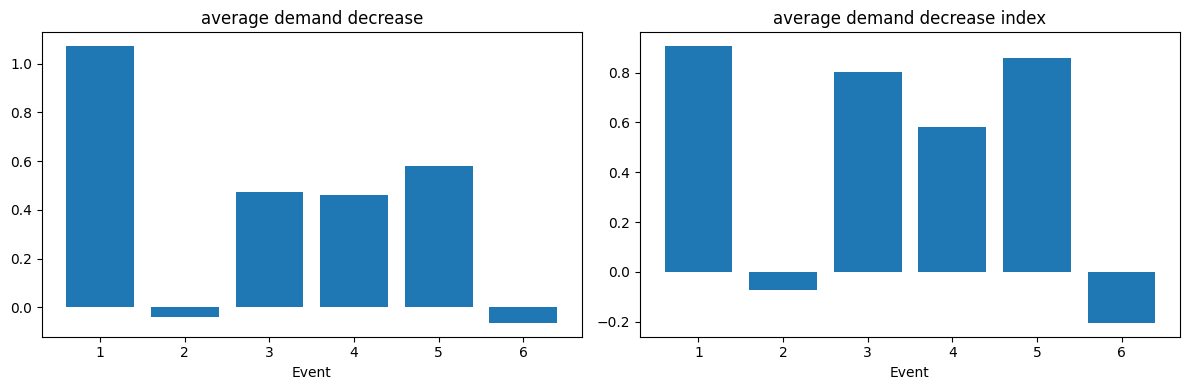

In [414]:
import numpy as np

if all(inner_list for inner_list in values_list_shed):
    # Create a dictionary to store the KPIs and their corresponding averages
    kpi_averages = {}

    # plot results
    kpis = [v[0] for v in values_list_shed[0]]
    #print(kpis)
    column_count_limit = 2
    row_count = math.ceil(len(kpis)/column_count_limit)
    column_count = min(column_count_limit, len(kpis))
    fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 4*row_count))
    daily_avg_values = []
    for ax in fig.axes[len(kpis):]:
        fig.delaxes(ax)

    for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
        values = [v[i][1] for v in values_list_shed]

        if isinstance(values[0], float):
            x = list(range(len(shed_signal_timestamps)))
            average = sum(values) / len(shed_signal_timestamps)
            print(f"The average for {kpi} is {average:.4f}")
            ax.bar(x, values)
            ax.set_xlabel('Event')

            kpi_averages[kpi] = average

            # Set custom x-labels
            x_labels = [str(i + 1) for i in range(len(x))]  # Generate labels from 1 to n
            ax.set_xticks(x)
            ax.set_xticklabels(x_labels)

        
        else:
            # calculate the average of the values
            avg_values = np.mean(values,axis=0)
            average = sum(avg_values) / len(avg_values)
            print(f"The average for {kpi} is {average:.2f}")
            
            kpi_averages[kpi] = average
            

            for j, v in enumerate(values):
                ax.plot(v, alpha=0.2)
            ax.plot(avg_values,label='Daily average', linewidth=2)
            ax.set_xlabel('Day')
            ax.legend(loc='upper left')  

            
        ax.set_title(kpi)


    print(kpi_averages)


    plt.tight_layout()
    plt.show()

In [415]:
values_list_shift = []

for s, e in shift_signal_timestamps:
    values = []
    
    if load_shifting.AverageDemandIncrease.info()["name"] in suitable_kpis:
        # load_shifting
        values.append((
            load_shifting.AverageDemandIncrease.NAME,
            load_shifting.AverageDemandIncrease.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))

    if load_shifting.AverageDemandIncreaseIntensity.info()["name"] in suitable_kpis:
        # load_shifting
        values.append((
            load_shifting.AverageDemandIncreaseIntensity.NAME,
            load_shifting.AverageDemandIncreaseIntensity.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
                #floor_area=floor_area,
        )))

    if load_shifting.AverageDemandIncreaseIndex.info()["name"] in suitable_kpis:
        # load_shifting
        values.append((
            load_shifting.AverageDemandIncreaseIndex.NAME,
            load_shifting.AverageDemandIncreaseIndex.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))
    
    values_list_shift.append(values)

print(values_list_shift)

[[('average demand increase', 1.1568162570416667), ('average demand increase index', 11.83729078154696)], [('average demand increase', -0.0010757499833333305), ('average demand increase index', -0.010982218909090458)], [('average demand increase', -0.11010421532500003), ('average demand increase index', -0.07254647598028419)], [('average demand increase', -0.89281935415), ('average demand increase index', -0.9034851278652847)], [('average demand increase', -0.3995748750249999), ('average demand increase index', -0.37449703966026726)], [('average demand increase', -0.5109006527666667), ('average demand increase index', -0.8424906311268432)]]


The average for average demand increase is -0.1263
The average for average demand increase index is 1.6055
{'average demand increase': -0.12627643170138889, 'average demand increase index': 1.6055482146675317}


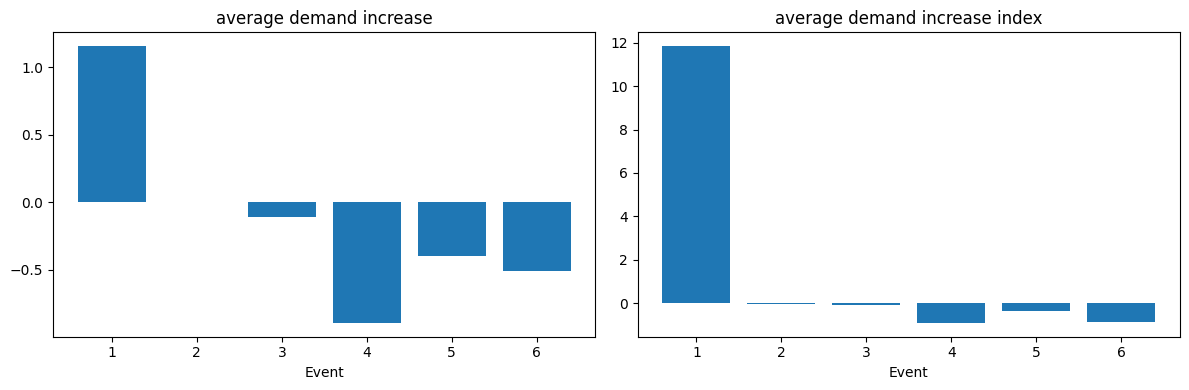

In [416]:

if all(inner_list for inner_list in values_list_shift):

    # Create a dictionary to store the KPIs and their corresponding averages
    kpi_averages = {}

    # plot results
    kpis = [v[0] for v in values_list_shift[0]]
    #print(kpis)
    column_count_limit = 2
    row_count = math.ceil(len(kpis)/column_count_limit)
    column_count = min(column_count_limit, len(kpis))
    fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 4*row_count))
    daily_avg_values = []
    for ax in fig.axes[len(kpis):]:
        fig.delaxes(ax)

    for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
        values = [v[i][1] for v in values_list_shift]

        if isinstance(values[0], float):
            x = list(range(len(shift_signal_timestamps)))
            average = sum(values) / len(shift_signal_timestamps)
            print(f"The average for {kpi} is {average:.4f}")
            ax.bar(x, values)
            ax.set_xlabel('Event')

            kpi_averages[kpi] = average

            # Set custom x-labels
            x_labels = [str(i + 1) for i in range(len(x))]  # Generate labels from 1 to n
            ax.set_xticks(x)
            ax.set_xticklabels(x_labels)

        
        else:
            # calculate the average of the values
            avg_values = np.mean(values,axis=0)
            average = sum(avg_values) / len(avg_values)
            print(f"The average for {kpi} is {average:.2f}")
            
            kpi_averages[kpi] = average
            

            for j, v in enumerate(values):
                ax.plot(v, alpha=0.2)
            ax.plot(avg_values,label='Daily average', linewidth=2)
            ax.set_xlabel('Day')
            ax.legend(loc='upper left')  

            
        ax.set_title(kpi)


    print(kpi_averages)


    plt.tight_layout()
    plt.show()

In [417]:
values_list_rebound = []

for s, e in rebound_signal_timestamps:
    values = []

    if peak_power_or_energy_rebound.AveragePowerRebound.info()["name"] in suitable_kpis:
        # peak_power_or_energy_rebound
        values.append((
            peak_power_or_energy_rebound.AveragePowerRebound.NAME,
            peak_power_or_energy_rebound.AveragePowerRebound.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))
   
    if peak_power_or_energy_rebound.AveragePowerReboundIndex.info()["name"] in suitable_kpis:
        # peak_power_or_energy_rebound
        values.append((
            peak_power_or_energy_rebound.AveragePowerReboundIndex.NAME,
            peak_power_or_energy_rebound.AveragePowerReboundIndex.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                generic_signal_start_timestamp=s,
                generic_signal_end_timestamp=e,
                timestamps=data.timestamp.tolist(),
        )))
    values_list_rebound.append(values)


print(values_list_rebound)

[[('average power rebound', -0.0009979305333333351), ('average power rebound index', -0.010266158923052715)], [('average power rebound', 1.3034478541583332), ('average power rebound index', 13.143701792179687)], [('average power rebound', -0.22861344440833334), ('average power rebound index', -0.7054424932186547)], [('average power rebound', 1.11358308335), ('average power rebound index', 11.362862398934048)], [('average power rebound', -1.4225662222), ('average power rebound index', -0.937028924620281)], [('average power rebound', 1.5102992861), ('average power rebound index', 15.622368478555583)]]


The average for average power rebound is 0.3792
The average for average power rebound index is 6.4127


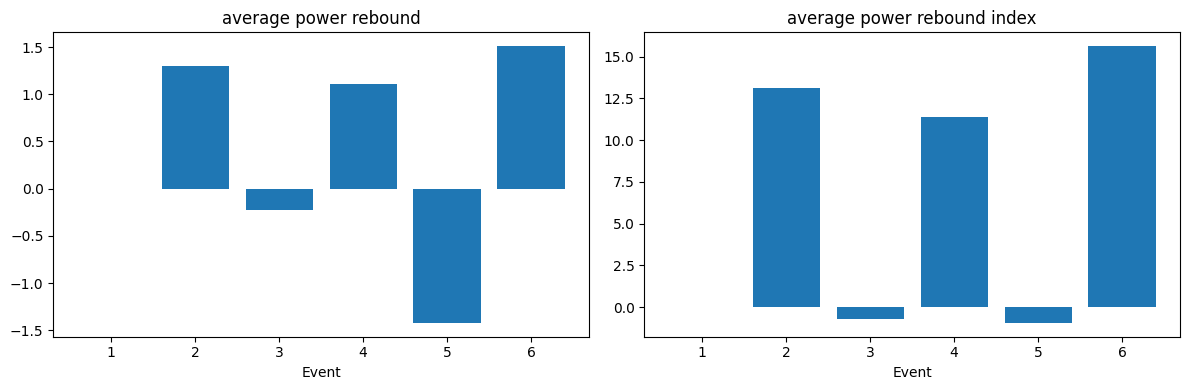

{'average power rebound': 0.37919210441111106, 'average power rebound index': 6.412699182151222}


<Figure size 640x480 with 0 Axes>

In [418]:
if all(inner_list for inner_list in values_list_rebound):

    # Create a dictionary to store the KPIs and their corresponding averages
    kpi_averages = {}

    # plot results
    kpis = [v[0] for v in values_list_rebound[0]]
    #print(kpis)
    column_count_limit = 2
    row_count = math.ceil(len(kpis)/column_count_limit)
    column_count = min(column_count_limit, len(kpis))
    fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 4*row_count))
    daily_avg_values = []
    for ax in fig.axes[len(kpis):]:
        fig.delaxes(ax)

    for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
        values = [v[i][1] for v in values_list_rebound]

        if isinstance(values[0], float):
            x = list(range(len(rebound_signal_timestamps)))
            average = sum(values) / len(rebound_signal_timestamps)
            print(f"The average for {kpi} is {average:.4f}")
            ax.bar(x, values)
            ax.set_xlabel('Event')

            kpi_averages[kpi] = average

            # Set custom x-labels
            x_labels = [str(i + 1) for i in range(len(x))]  # Generate labels from 1 to n
            ax.set_xticks(x)
            ax.set_xticklabels(x_labels)

        
        else:
            # calculate the average of the values
            avg_values = np.mean(values,axis=0)
            average = sum(avg_values) / len(avg_values)
            print(f"The average for {kpi} is {average:.2f}")
            
            kpi_averages[kpi] = average
            

            for j, v in enumerate(values):
                ax.plot(v, alpha=0.2)
            ax.plot(avg_values,label='Daily average', linewidth=2)
            ax.set_xlabel('Day')
            ax.legend(loc='upper left')  

            
        ax.set_title(kpi)

    plt.tight_layout()
    plt.show()

    print(kpi_averages)


    plt.tight_layout()
    plt.show()


In [420]:

values_list_evaluation = []

for s, e in evaluation_timestamps:
    
    values = []
    print(s, e )
    
    if demand_response_costs_or_savings.FlexibilitySavingsIndex.info()["name"] in suitable_kpis:
        # demand_response_costs_or_savings
        values.append((
            demand_response_costs_or_savings.FlexibilitySavingsIndex.NAME,
            demand_response_costs_or_savings.FlexibilitySavingsIndex.calculate(
                data_price_merge.baseline_cost_profile.tolist(),
                data_price_merge.flexible_cost_profile.tolist(),
                timestamps=data_price_merge.timestamp.tolist(),
                evaluation_start_timestamp=s,
                evaluation_end_timestamp=e,
        )))
    
    
    if demand_response_energy_efficiency.EnergySavingsOfDemandResponse.info()["name"] in suitable_kpis:
        # demand_response_energy_efficiency
        values.append((
            demand_response_energy_efficiency.EnergySavingsOfDemandResponse.NAME,
            demand_response_energy_efficiency.EnergySavingsOfDemandResponse.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                timestamps=data.timestamp.tolist(),
                evaluation_start_timestamp=s,
                evaluation_end_timestamp=e,
        )))

    
    if demand_response_energy_efficiency.NetBuildingConsumptionChangePercentage.info()["name"] in suitable_kpis:
        # demand_response_energy_efficiency
        values.append((
            demand_response_energy_efficiency.NetBuildingConsumptionChangePercentage.NAME,
            demand_response_energy_efficiency.NetBuildingConsumptionChangePercentage.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                timestamps=data.timestamp.tolist(),
                evaluation_start_timestamp=s,
                evaluation_end_timestamp=e,
        )))


    if peak_power_shedding.PeakPowerReduction.info()["name"] in suitable_kpis:
        # Peak power shedding
        values.append((
            peak_power_shedding.PeakPowerReduction.NAME, 
            peak_power_shedding.PeakPowerReduction.calculate(
                data.baseline_electric_power_profile.tolist(),
                data.flexible_electric_power_profile.tolist(),
                timestamps=data.timestamp.tolist(),
                evaluation_start_timestamp=s,
                evaluation_end_timestamp=e,
        )))


    values_list_evaluation.append(values)
print(values_list_evaluation)

2016-07-08 00:00:00 2016-07-10 23:59:59
[[('flexibility savings index', -0.0742754565931476), ('energy savings of demand response', -23.03944831055496), ('net building consumption change percentage', 66.036959584758), ('peak power reduction', 0.5838087699619052)]]


The average for flexibility savings index is -0.0743
The average for energy savings of demand response is -23.0394
The average for net building consumption change percentage is 66.0370
The average for peak power reduction is 0.5838


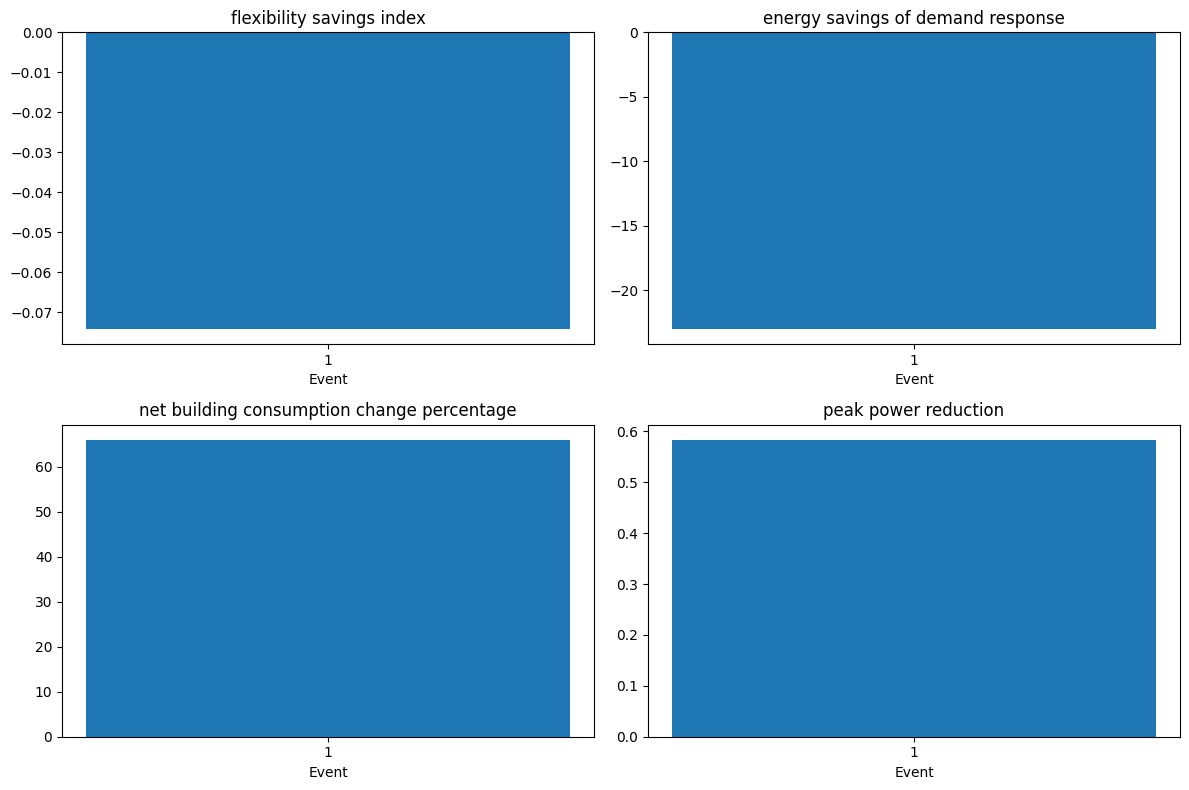

{'flexibility savings index': -0.0742754565931476, 'energy savings of demand response': -23.03944831055496, 'net building consumption change percentage': 66.036959584758, 'peak power reduction': 0.5838087699619052}


<Figure size 640x480 with 0 Axes>

In [421]:
if all(inner_list for inner_list in values_list_evaluation):

    # Create a dictionary to store the KPIs and their corresponding averages
    kpi_averages = {}

    # plot results
    kpis = [v[0] for v in values_list_evaluation[0]]
    #print(kpis)
    column_count_limit = 2
    row_count = math.ceil(len(kpis)/column_count_limit)
    column_count = min(column_count_limit, len(kpis))
    fig, _ = plt.subplots(row_count, column_count, figsize=(6*column_count, 4*row_count))
    daily_avg_values = []
    for ax in fig.axes[len(kpis):]:
        fig.delaxes(ax)

    for i, (ax, kpi) in enumerate(zip(fig.axes, kpis)):
        values = [v[i][1] for v in values_list_evaluation]

        if isinstance(values[0], float):
            x = list(range(len(evaluation_timestamps)))
            average = sum(values) / len(evaluation_timestamps)
            print(f"The average for {kpi} is {average:.4f}")
            ax.bar(x, values)
            ax.set_xlabel('Event')

            kpi_averages[kpi] = average

            # Set custom x-labels
            x_labels = [str(i + 1) for i in range(len(x))]  # Generate labels from 1 to n
            ax.set_xticks(x)
            ax.set_xticklabels(x_labels)

        
        else:
            # calculate the average of the values
            avg_values = np.mean(values,axis=0)
            average = sum(avg_values) / len(avg_values)
            print(f"The average for {kpi} is {average:.2f}")
            
            kpi_averages[kpi] = average
            

            for j, v in enumerate(values):
                ax.plot(v, alpha=0.2)
            ax.plot(avg_values,label='Event average', linewidth=2)
            ax.set_xlabel('Event')
            ax.legend(loc='upper left')  

            
        ax.set_title(kpi)

    plt.tight_layout()
    plt.show()

    print(kpi_averages)


    plt.tight_layout()
    plt.show()

